# Lending Value model for SMI stocks

In [2]:
# Loading packages
import numpy as np
import pandas as pd
import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import statsmodels
from scipy import stats

In [3]:
# Calculate log returns
def log_returns(prices):
    return np.log(prices/prices.shift(1))

def ADTV(volumes):
    adtv = pd.DataFrame(data=[volumes.iloc[-20:,:].mean(),
                              volumes.iloc[-250*3:,:].mean()],
                        index=['ADTV - Last month','ADTV - Last three years']) \
                        .transpose()
    return adtv

# Return mean of a time series
def mean(log_prices):
    return log_prices.mean()

# Return standard deviation of a time series
def std(log_prices):
    return log_prices.std()

# Return drift and diffusion used to model the asset price process
def GBM(log_prices):
    mu = log_prices.mean()
    sigma = log_prices.std()
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    return drift, diffusion

# Lending Value (not adjusted)
def LV(log_prices,alpha,epsilon,delta):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv = ( (1-alpha)*(np.exp(drift+delta)*stats.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) )
    return lv

# Lending Value adjusted for liquidity
def LV_adj(log_prices,alpha,epsilon,delta,gamma,x):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv_adj = ( (1-alpha)*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) )
    return lv_adj

# Estimate gamma by using ADTV
def gamma_est(ADTV,a_hat,b_hat):
    return 10**a_hat*ADTV**b_hat

## Get the data

In [82]:
smi_prices = pd.read_csv('data/smi_prices.csv',index_col='Date')
smi_logreturns = log_returns(smi_prices)
smi_vols = pd.read_csv('data/smi_volumes.csv',index_col='Date')

# --- SMI ---

## Base LV model

In [5]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

a_hat_juri = -1.87096
b_hat_juri = -0.794554

In [6]:
# Base LV model for smi20
smi_n = len(smi_logreturns.columns) # number of assets
smi_names = list(smi_logreturns.columns) # names of firms

smi_lvs = []
for i in range(smi_n):
    lv = LV(smi_logreturns.iloc[:,i],alpha,epsilon,delta)
    smi_lvs.append(lv*100)
smi_lvs = pd.DataFrame(smi_lvs,index=smi_names)
smi_lvs.columns = ['% Lending Value']

In [7]:
smi_lvs_gbm = pd.concat([smi_lvs,
                         pd.Series(GBM(smi_logreturns)[0]*100,name='% Drift'),
                         pd.Series(GBM(smi_logreturns)[1]*100,name='% Diffusion')],axis=1)\
                    .sort_values('% Lending Value',ascending=False).round(2)
smi_lvs_gbm

,% Lending Value,% Drift,% Diffusion
Nestle,90.87,0.53,0.11
Swisscom,89.79,0.24,0.13
Givaudan,89.51,0.71,0.15
Novartis,88.68,0.30,0.16
Roche,88.60,0.50,0.17
SGS,88.57,0.25,0.17
Geberit,88.07,0.52,0.19
Zurich Insurance Group,86.58,0.48,0.24
Partners Group,86.44,0.77,0.26
ABB,85.71,0.44,0.28


## Adjusted Lending Value Model

In [8]:
smi_adtv = ADTV(smi_vols)['ADTV - Last month']
smi_adtv.name = 'ADTV'

smi_gamma = []
for i in smi_adtv:
    est_i = gamma_est(i,a_hat_juri,b_hat_juri)
    smi_gamma.append(est_i)
smi_gamma = pd.Series(smi_gamma,index=smi_names,name='Gamma')

smi_liq = pd.concat([smi_adtv.round(0).astype(int),
                     smi_gamma],
                    axis=1).sort_values('ADTV',ascending=False)
smi_liq

,ADTV,Gamma
Credit Suisse,19667326,2.156580e-08
UBS,14850055,2.695968e-08
ABB,6338460,5.302695e-08
Novartis,5902735,5.611417e-08
Nestle,4974456,6.428564e-08
LafargeHolcim,1982232,1.335398e-07
Roche,1718565,1.495767e-07
Richemont,1389445,1.771009e-07
Swiss Re,1295295,1.872548e-07
Alcon,985499,2.326785e-07


In [9]:
smi_adjlvs_x0 = []
smi_adjlvs_xthousand = []
smi_adjlvs_xmil = []
smi_adjlvs_x2adtv = []

for i in range(smi_n):
    adjlv = LV_adj(smi_logreturns.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  0)
    smi_adjlvs_x0.append(adjlv)

for i in range(smi_n):
    adjlv = LV_adj(smi_logreturns.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  smi_adtv[i]*2)
    smi_adjlvs_xthousand.append(adjlv)
    
for i in range(smi_n):
    adjlv = LV_adj(smi_logreturns.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  smi_adtv[i]*2)
    smi_adjlvs_xmil.append(adjlv)
    
for i in range(smi_n):
    adjlv = LV_adj(smi_logreturns.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  smi_adtv[i]*2)
    smi_adjlvs_x2adtv.append(adjlv)

smi_adjlvs = pd.DataFrame([smi_adjlvs_x0,smi_adjlvs_xthousand,smi_adjlvs_xmil,smi_adjlvs_x2adtv],
                          index=['x = 0','x = 1 000','x =1 000 000','x = ADTV x 2'],
                          columns=smi_names).T.sort_values('x = 0',ascending=False).round(4)*100
smi_adjlvs

,x = 0,x = 1 000,x =1 000 000,x = ADTV x 2
Nestle,90.87,41.93,41.93,41.93
Swisscom,89.79,60.12,60.12,60.12
Givaudan,89.51,68.20,68.20,68.20
Novartis,88.68,40.00,40.00,40.00
Roche,88.60,47.36,47.36,47.36
SGS,88.57,67.76,67.76,67.76
Geberit,88.07,61.28,61.28,61.28
Zurich Insurance Group,86.58,52.95,52.95,52.95
Partners Group,86.44,62.66,62.66,62.66
ABB,85.71,38.39,38.39,38.39


# --- Selected Stocks ---

In [10]:
# Select the most liquid, 8th liquid, 14th liquid and the least liquid stock in the SMI index
selection = [0,7,13,19]
selected_adtv = smi_adtv.sort_values(ascending=False)[selection]
selected_names = list(selected_adtv.index)
selected_names

['Credit Suisse', 'Richemont', 'Swisscom', 'SGS']

In [11]:
selected_lvs_gbm = smi_lvs_gbm.loc[selected_names,:]
selected_lvs_gbm

,% Lending Value,% Drift,% Diffusion
Credit Suisse,79.36,-0.71,0.54
Richemont,83.69,0.09,0.35
Swisscom,89.79,0.24,0.13
SGS,88.57,0.25,0.17


In [12]:
smi_liq.loc[selected_names]

,ADTV,Gamma
Credit Suisse,19667326,2.156580e-08
Richemont,1389445,1.771009e-07
Swisscom,176108,9.140826e-07
SGS,23449,4.536671e-06


In [13]:
selected_adjlvs = smi_adjlvs.loc[selected_names]
selected_adjlvs

,x = 0,x = 1 000,x =1 000 000,x = ADTV x 2
Credit Suisse,79.36,29.51,29.51,29.51
Richemont,83.69,46.16,46.16,46.16
Swisscom,89.79,60.12,60.12,60.12
SGS,88.57,67.76,67.76,67.76


### Adjusted LV for SGS stock

In [14]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

x_range = np.arange(0,10**8,10**3)

In [15]:
def lvx(log_returns,alpha,epsilon,delta,gamma,x_range):
    lvs = []
    for i in range(len(x_range)):
        lv_adj = LV_adj(log_returns,
                        alpha,epsilon,delta,
                        gamma,
                        x_range[i])
        lvs.append(lv_adj)
    return lvs

In [16]:
cs_lvx = lvx(smi_logreturns.loc[:,'Credit Suisse'],
             alpha,epsilon,delta,
             smi_gamma['Credit Suisse'],
             x_range)
rich_lvx = lvx(smi_logreturns.loc[:,'Richemont'],
             alpha,epsilon,delta,
             smi_gamma['Richemont'],
             x_range)
scom_lvx = lvx(smi_logreturns.loc[:,'smisscom'],
             alpha,epsilon,delta,
             smi_gamma['smisscom'],
             x_range)
sgs_lvx = lvx(smi_logreturns.loc[:,'SGS'],
             alpha,epsilon,delta,
             smi_gamma['SGS'],
             x_range)

In [169]:
len(x_range)

100000

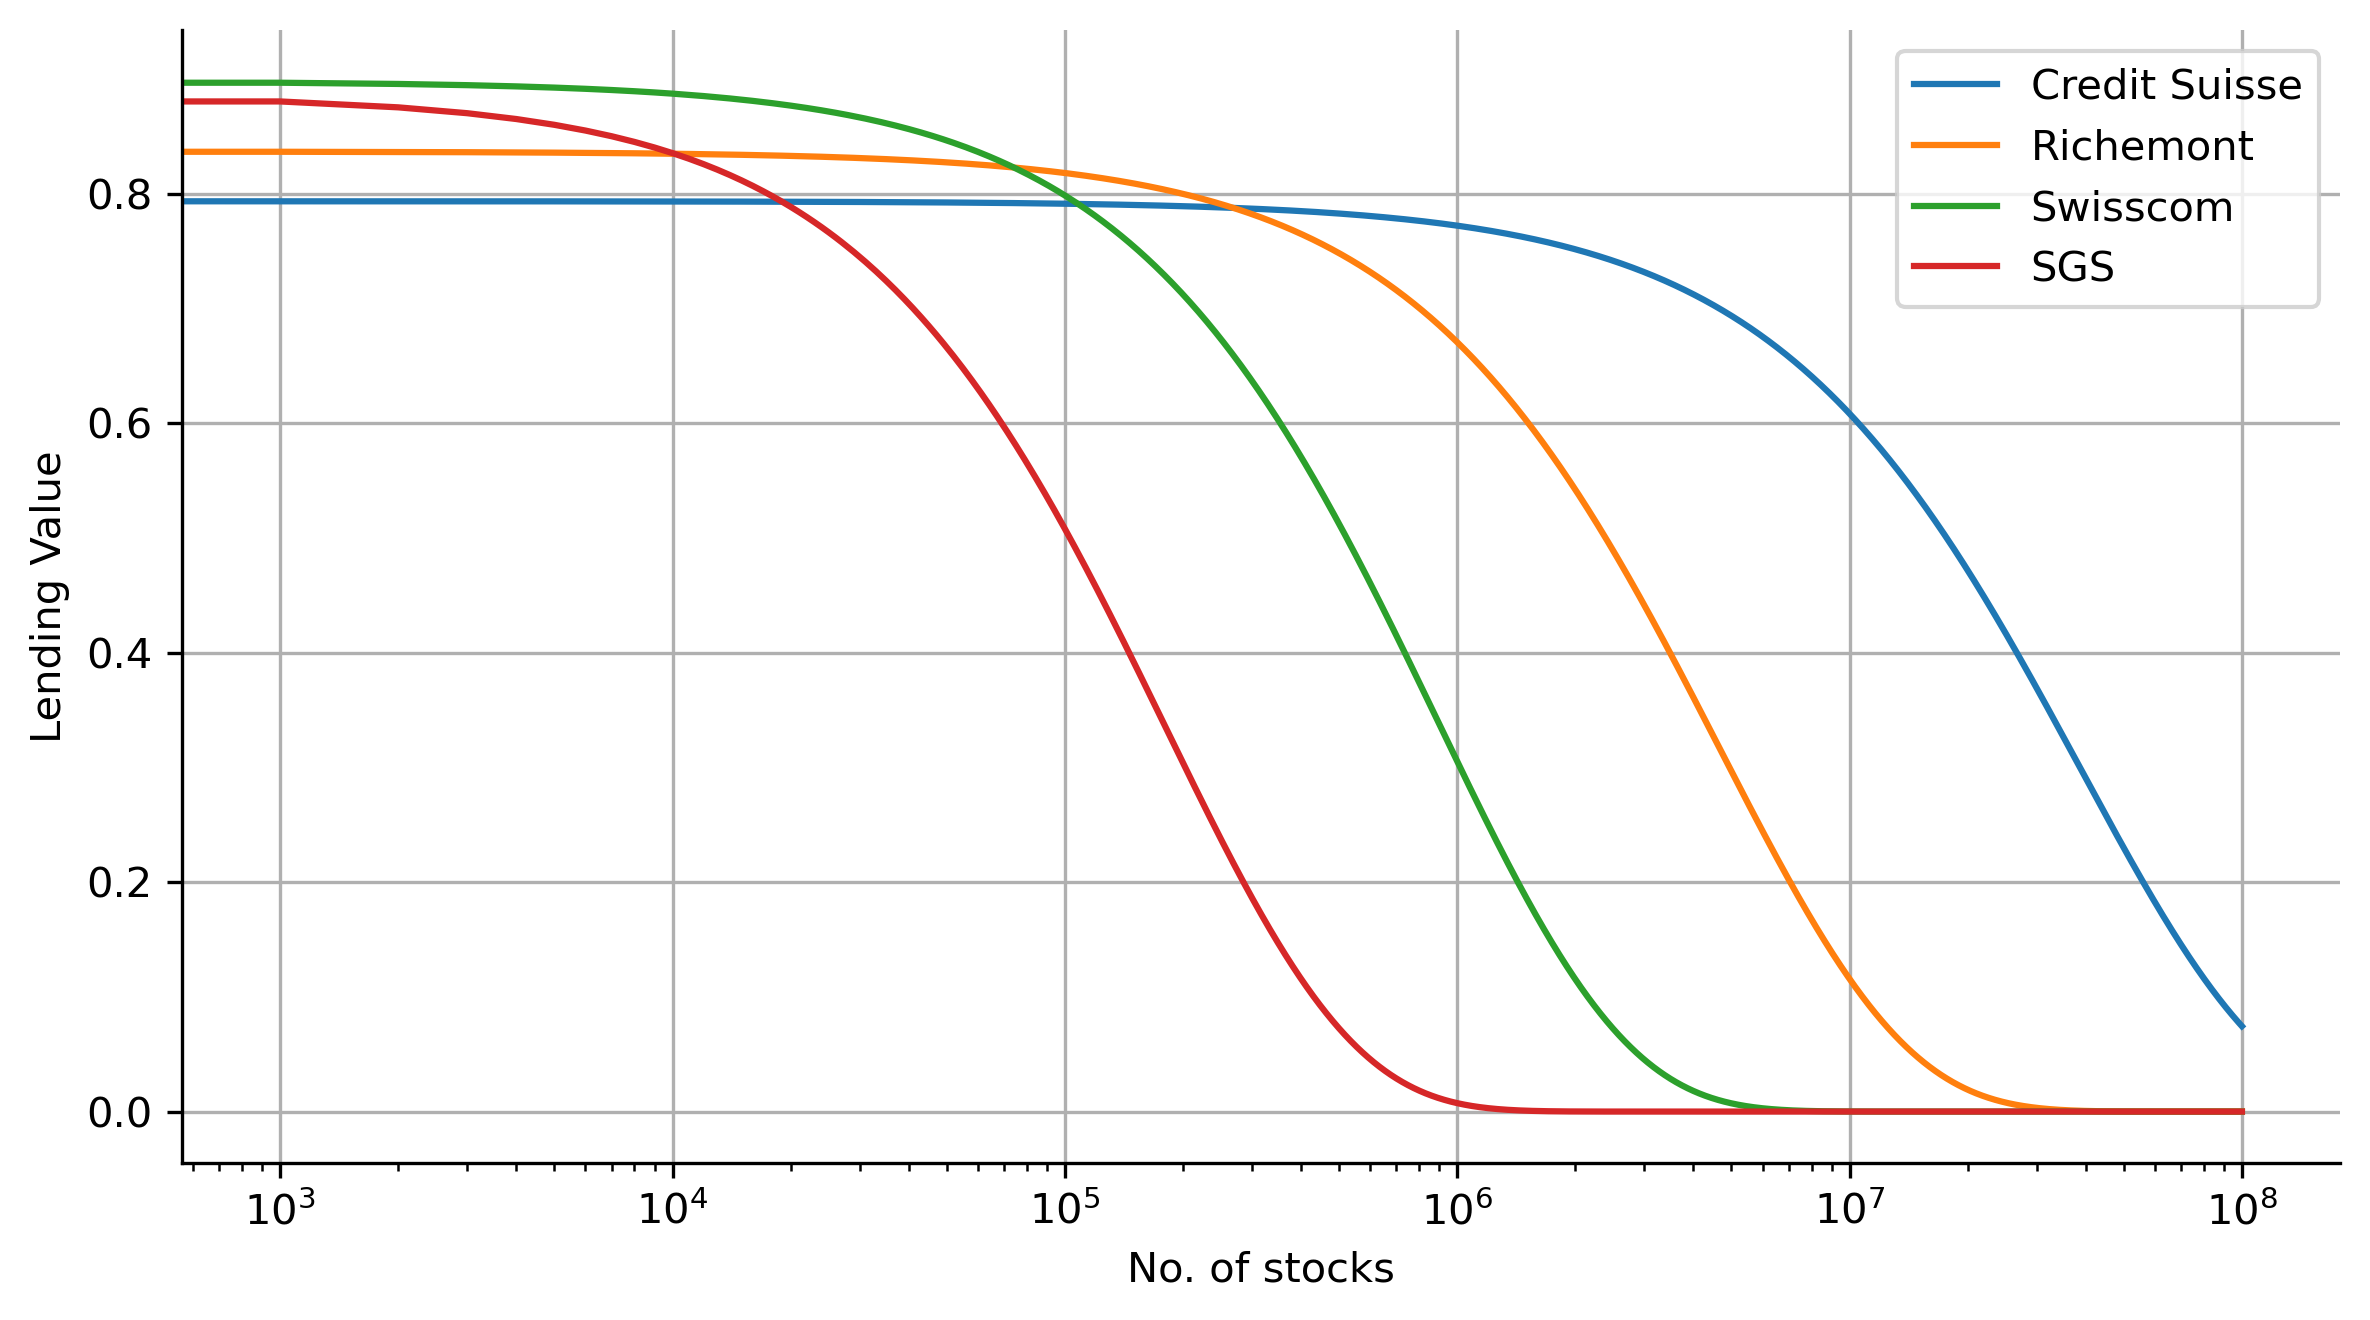

In [32]:
fig_ ,ax = plt.subplots(1,1,figsize=[16/2,9/2],dpi=300)
ax.plot(x_range,cs_lvx)
ax.plot(x_range,rich_lvx)
ax.plot(x_range,scom_lvx)
ax.plot(x_range,sgs_lvx)

ax.set_xscale('log')
ax.set_xlabel('No. of stocks')
ax.set_ylabel('Lending Value')
ax.legend(selected_names)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
plt.tight_layout()

## Dist

In [47]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

def beta(lv,alpha):
    return (1 - (1 - lv)*alpha)

In [66]:
cs_lv = smi_lvs.loc['Credit Suisse'][0] / 100
rich_lv = smi_lvs.loc['Richemont'][0] / 100
scom_lv = smi_lvs.loc['Swisscom'][0] / 100
sgs_lv = smi_lvs.loc['SGS'][0] / 100

cs_beta = beta(cs_lv,alpha)
rich_beta = beta(rich_lv,alpha)
scom_beta = beta(scom_lv,alpha)
sgs_beta = beta(sgs_lv,alpha)

In [77]:
np.array([cs_lv/cs_beta,
      rich_lv/rich_beta,
      scom_beta/scom_lv,
      sgs_beta/sgs_lv])

array([0.83675185, 0.87245925, 1.08524016, 1.09674208])

In [78]:
np.log(cs_lv/cs_beta)

-0.1782277274238515

In [91]:
cs_logs = smi_logreturns['Credit Suisse']

In [93]:
GBM(cs_logs)[0]

-0.007053942705546501

In [ ]:

# Return drift and diffusion used to model the asset price process
def GBM(log_prices):
    mu = log_prices.mean()
    sigma = log_prices.std()
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    return drift, diffusion


In [97]:
cs_d = ( np.log(cs_lv/cs_beta) - GBM(cs_logs)[0] ) / np.sqrt(GBM(cs_logs)[1] )

#stats.norm.cdf()

In [107]:
np.exp( GBM(cs_logs)[0] + np.sqrt(GBM(cs_logs)[1]) * stats.norm.ppf(epsilon) )

0.8367518504469327

In [111]:
LV(cs_logs,alpha,epsilon,delta)

0.7935689622375879

In [126]:
LV(cs_logs.iloc[1:20],
   alpha,epsilon,delta)

0.9124094737064214

In [145]:
LV(cs_logs.iloc[20:200],
   alpha,epsilon,delta)

0.8436599945121691

In [ ]:
def LV_series(logs):
    lvs = []
    for i in range(20,len(logs)):
        lv = LV(logs.iloc[20:20+i],alpha,epsilon,delta)
        lvs.append(lv)
    lvs = pd.Series(ll,index=cs_logs.index[20:])

In [159]:
ll = []
for i in range(20,len(cs_logs)):
    a = LV(cs_logs.iloc[20:20+i],alpha,epsilon,delta)
    ll.append(a)
ll = pd.Series(ll,index=cs_logs.index[20:])

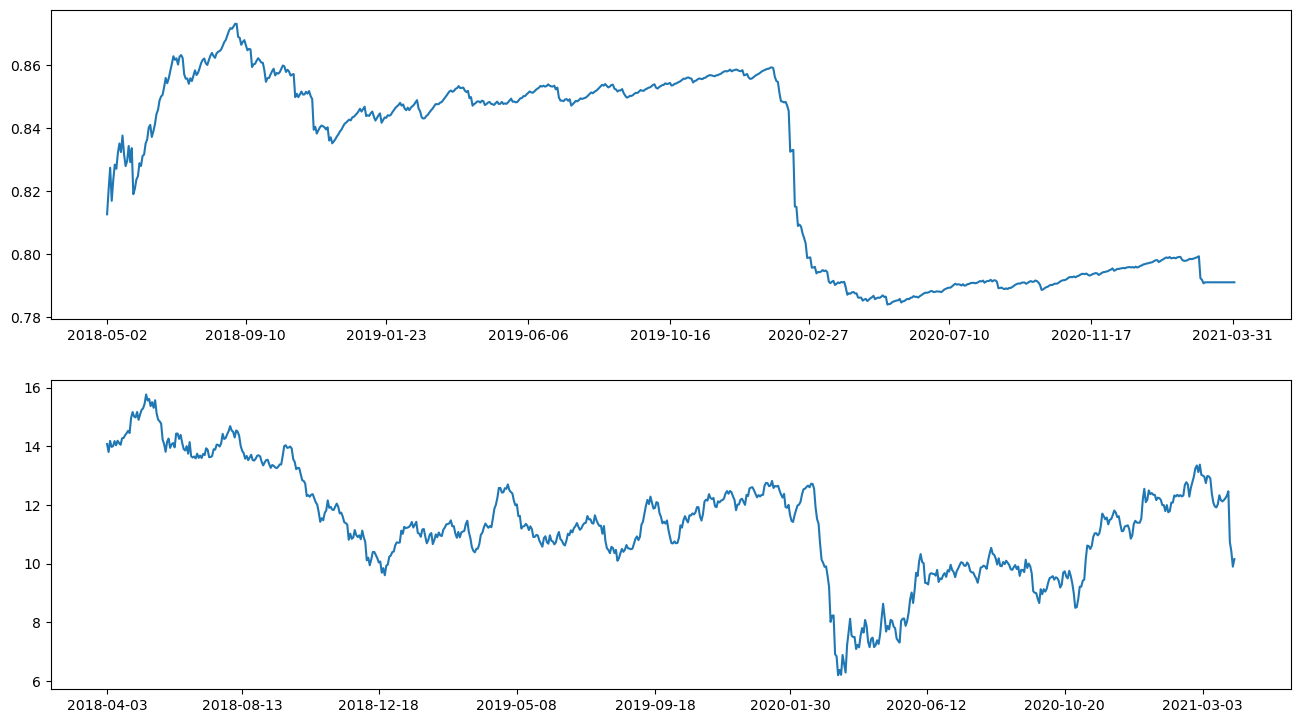

In [167]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(2,1,figsize=[16,9],dpi=100)
ax[0].plot(ll)
ax[0].xaxis.set_major_locator(mdates.AutoDateLocator())
ax[1].plot(smi_prices['Credit Suisse'])
ax[1].xaxis.set_major_locator(mdates.AutoDateLocator())